<a href="https://colab.research.google.com/github/SlickMik/ensf692Project/blob/main/ENSF_692_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 2

Autosaving every 2 seconds


# ESNF 692 Project
### Group # : 4
##### Authors : Danish Shahid () | Muhammad Ibrahim Khan ()
##### Date : June 19, 2025
---

This notebook describes the analysis and correlation of asset classes - Oil, Gold, and S&P500 for a user selected time range.

---

Importing Libraries

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib as mp
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates

# Dataset Selection

Downloading Kaggle Datasets

In [ ]:
# Download latest dataset versions
gold_dataset_path = kagglehub.dataset_download("faisaljanjua0555/daily-gold-price-historical-dataset")

oil_dataset_path = kagglehub.dataset_download("guillemservera/fuels-futures-data")

sp_dataset_path = kagglehub.dataset_download("youcanttouchthis/s-p-500-dataset")

100%|██████████| 87.0k/87.0k [00:00<00:00, 35.6MB/s]

Extracting files...


100%|██████████| 1.21M/1.21M [00:00<00:00, 51.6MB/s]

Extracting files...


100%|██████████| 179k/179k [00:00<00:00, 51.7MB/s]

Extracting files...


# Dataset Creation

* Reading Dataset to Pandas<br/>
* Dropping unnecessary columns<br/>
* Setting index to Date<br/>
* Parsing Date

In [ ]:
# read csv files into pandas
gold_dataset = pd.read_csv(gold_dataset_path + f'/gold.csv', index_col='Date', parse_dates=True)

oil_dataset = pd.read_csv(oil_dataset_path + f'/all_fuels_data.csv', index_col='date', parse_dates=True)

sp_dataset = pd.read_csv(sp_dataset_path + f'/spy.csv', index_col='Date', parse_dates=True)

Gold Dataset
* Dropping Columns
* Renaming Columns

Describing Gold Dataset

In [ ]:
gold_dataset = gold_dataset.drop(columns='Currency').rename(columns = {c : f'Gold_{c}' for c in gold_dataset.columns})
gold_dataset.head(3)

,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume
Date,,,,,
2000-01-04,289.5,289.5,280.0,283.7,21621
2000-01-05,283.7,285.0,281.0,282.1,25448
2000-01-06,281.6,282.8,280.2,282.4,19055


Oil Dataset
* Dropping Columns
* Reorganizing Columns
* Renaming Columns
* Cleaning Columns

Describing Oil Dataset

In [ ]:
oil_dataset = oil_dataset[oil_dataset['commodity'].str.lower().str.fullmatch('crude oil')]
oil_dataset = oil_dataset.drop(columns=['ticker', 'commodity'])
oil_dataset.rename_axis(index={'date':'Date'}, inplace=True)
oil_dataset.columns = oil_dataset.columns.str.capitalize()

oil_dataset = (
    oil_dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
    .rename(columns={c : f'Oil_{c.title()}' for c in oil_dataset.columns})
)
oil_dataset.head(3)

,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Volume
Date,,,,,
2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2000-08-25,31.700001,32.099998,31.320000,32.049999,44601


S&P 500 Dataset
* Dropping Columns
* Renaming Columns

Describing S&P 500 Dataset

In [ ]:
sp_dataset = sp_dataset.drop(columns='Adj Close').rename(columns = {c : f'S&P500_{c}' for c in sp_dataset.columns})
sp_dataset.head(3)

,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Close,S&P500_Volume
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300


Join Datasets

In [ ]:
close_cols = ['S&P500_Close', 'Gold_Close', 'Oil_Close']
assets_df = sp_dataset[[close_cols[0]]].join(gold_dataset[[close_cols[1]]], how='outer').join(oil_dataset[[close_cols[2]]], how='outer')
assets_df.head(3)

,S&P500_Close,Gold_Close,Oil_Close
Date,,,
1993-01-29,43.93750,NaN,NaN
1993-02-01,44.25000,NaN,NaN
1993-02-02,44.34375,NaN,NaN


Drop Duplicated Columns If Any

In [ ]:
if assets_df.columns.duplicated().any():
  assets_df = assets_df.T.drop_duplicates().T

Set Hierarchical Index on Rows

In [ ]:
assets_df = assets_df.set_index(
    pd.MultiIndex.from_arrays(
        [assets_df.index.year,assets_df.index.month, assets_df.index.day], names=['Year', 'Month', 'Day']
        )
    )
assets_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
1993 1     29       43.93750         NaN        NaN
     2     1        44.25000         NaN        NaN
           2        44.34375         NaN        NaN

In [ ]:
assets_df.describe()

,S&P500_Close,Gold_Close,Oil_Close
count,7029.000000,5703.000000,5984.000000
mean,143.519237,1040.298282,64.477543
std,71.069322,518.524020,25.297096
min,43.406250,256.600000,-37.630001
25%,99.730003,460.500000,45.317501
50%,127.080002,1188.700000,63.075001
75%,181.119995,1383.050000,83.279997
max,372.239990,2069.400000,145.289993


---

# User Entry

In [ ]:
def get_user_input():
    print("Enter a start and end date between the range of 2000-08-23 & 2020-12-24 or enter 'n' to exit program")
    min_date = pd.to_datetime('2000-08-23')
    max_date = pd.to_datetime('2020-12-24')

    while True:
        try:
            start_input = input('Enter the start date (e.g YYYY-MM-DD): ')
            if start_input.lower() == 'n':
                print("Program exited.")
                return None, None, None

            end_input = input('Enter the end date (e.g YYYY-MM-DD): ')
            if end_input.lower() == 'n':
                print("Program exited.")
                return None, None, None

            start_date = pd.to_datetime(start_input)
            end_date = pd.to_datetime(end_input)

            rolling_period = input("Enter rolling period (e.g 20): ")
            if rolling_period.lower() == 'n':
                print("Program exited.")
                return None, None, None

            rolling_period = int(rolling_period)

            if not (min_date <= start_date <= max_date):
                raise ValueError(f"Start date must be between {min_date.date()} and {max_date.date()}")
            if not (min_date <= end_date <= max_date):
                raise ValueError(f"End date must be between {min_date.date()} and {max_date.date()}")
            if start_date > end_date:
                raise ValueError("Start date must be before or equal to end date.")
            if rolling_period > 200:
                raise ValueError("Rolling period must be lower than or equal to 200")

            return start_date, end_date, rolling_period

        except Exception as e:
            print(f"Invalid input: {e}")


In [ ]:
start_date, end_date, rolling_period = get_user_input()

if start_date and end_date and rolling_period:
    print(f"Start Date: {start_date.date()}")
    print(f"End Date: {end_date.date()}")
    print(f"Rolling Period: {rolling_period}")

Enter a start and end date between the range of 2000-08-23 & 2020-12-24 or enter 'n' to exit program
Enter the start date (e.g YYYY-MM-DD): 2000-08-23
Enter the end date (e.g YYYY-MM-DD): 2020-12-24
Enter rolling period (e.g 20): 20
Start Date: 2000-08-23
End Date: 2020-12-24
Rolling Period: 20


Slicing Joined Asset Data Frame by Index

In [94]:
range_asset_df = assets_df.loc[(start_date.year, start_date.month, start_date.day):(end_date.year, end_date.month, end_date.day)]
range_asset_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
2000 8     23      150.84375       275.7  32.049999
           24      151.31250       277.5  31.629999
           25      151.25000       278.6  32.049999

---

# Analysis & Visualization

### **Simple Moving Average (SMA)** - Normalized

A simple moving average (SMA) measures the average price of an asset—typically using closing prices—over a specified number of days[^1].

* The simple moving average reflects the average price across a defined time frame.
* As a technical indicator, the simple moving average helps identify whether an asset’s price is likely to continue or reverse its current bull or bear trend.
* The simple moving average also helps filter out daily noise (random price fluctuations), making the overall price trend appear smoother.

The formula for the simple moving average (SMA) over $n$ periods is[^2]:

$$
\mathrm{SMA}_t = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}
$$

where:  
- $\mathrm{SMA}_t$ = Simple Moving Average at time $t$  
- $n$ = Number of periods  
- $P_{t-i}$ = Price at period $t-i$

Similarly,

$$
\text{Normalized SMA}_t = \frac{\mathrm{SMA}_t}{P_0}
$$

where:  
- $\text{Normalized SMA}_t$ = Normalized simple moving average at time $t$  
- $\mathrm{SMA}_t$ = Simple moving average at time $t$  
- $P_0$ = First (initial) price in your data

---

[^1]: Investopedia. "Simple Moving Average (SMA): Definition, Calculation, and Examples." [Link](https://www.investopedia.com/terms/s/sma.asp)<br/>
[^2] GPT LLM

In [95]:
sma_cols = {f'{x}' : f"""{x.replace('_Close', '')}_{rolling_period}-day_SMA""" for x in close_cols}
range_asset_df = pd.concat([range_asset_df,
                           range_asset_df[[*sma_cols.keys()]]
                           .rolling(window=rolling_period)
                           .mean().rename(columns = sma_cols).bfill()],
                           axis = 1)
range_asset_df[[*sma_cols.values()]] /=  range_asset_df[[*sma_cols.values()]].iloc[0]

S&P500_20-day_SMA  Gold_20-day_SMA  Oil_20-day_SMA
Year Month Day                                                    
2000 9     21            0.997274         0.999603        1.002782
           22            0.995258         0.999171        1.004276
           25            0.992918         0.998936        1.003573

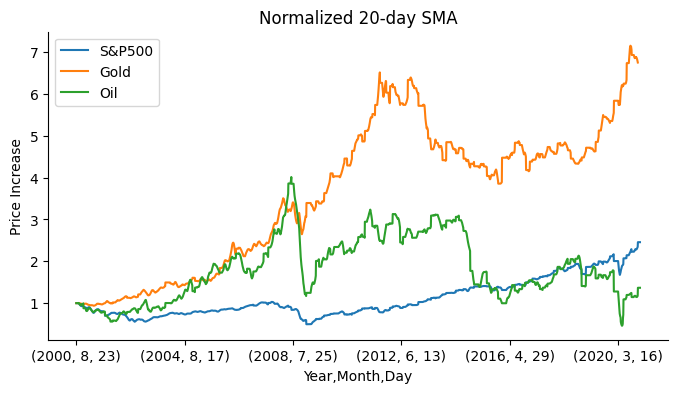

In [96]:
legend_text = ['S&P500', 'Gold', 'Oil']
ax = range_asset_df[[*sma_cols.values()]].plot(kind='line', figsize=(8, 4), title=f'Normalized {rolling_period}-day SMA')
ax.set_ylabel('Price Increase')
ax.legend(legend_text)
plt.gca().spines[['top', 'right']].set_visible(False)


display(range_asset_df[[*sma_cols.values()]].iloc[rolling_period : rolling_period + 3])

##### **Conclusion**:

Plotting the normalized SMA for each asset class over a set period and rolling window shows their relative growth and price trends. This approach helps compare performance and volatility across different assets consistently.

---

### **Percent Change & Cummulative (Total) Return**

Percentage change is a metric that helps investors measure how well an asset performs, like a stock, commodity, or other investment, over a certain period[^1].

Investors often compare the percentage change of individual assets or portfolios to benchmarks or similar assets during the same time frame to evaluate their performance.

This method is not limited to investments; percentage change can also show how the value of everyday items changes. For example, it can track how much the price of oil or gold has increased or decreased over time.

* Analysts and investors use percentage change to look at the growth or drop in asset value over time.
* Tracking percentage changes across different assets helps investors make better decisions about adjustments or rebalancing in their portfolios.
* Percentage change is a useful tool for evaluating price shifts in investments, commodities, and other financial measures.

The formula to calculate the percentage change in price is[^2]:

$$
\text{Percentage Change} = \frac{P_{\text{current}} - P_{\text{previous}}}{P_{\text{previous}}} \times 100
$$

where:  
- $P_{\text{current}}$ = Current price or value  
- $P_{\text{previous}}$ = Previous price or value

Similarly,

The formula to calculate **cumulative (total) return** from a series of daily percentage changes ($r_1, r_2, ..., r_n$) is[^3]:

$$
\text{Cumulative Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right) - 1
$$

where:  
- $r_i$ = Daily return (as a decimal, e.g., 0.01 for 1%) on day $i$  
- $n$ = Total number of days

---

[^1]: Investopedia. "Percentage Change: Definition, Formula, and Examples." [https://www.investopedia.com/terms/p/percentage-change.asp](https://www.investopedia.com/terms/p/percentage-change.asp)<br/>
[^2] GPT LLM<br/>
[^3] Investopedia. "Cumulative Return: Definition, Calculation, and Example." [https://www.investopedia.com/terms/c/cumulativereturn.asp](https://www.investopedia.com/terms/c/cumulativereturn.asp)

In [97]:
perc_cols = {f'{x}' : f"""{x.replace('_Close', '')}_%Return""" for x in close_cols}
cum_cols = {f'{x}' : f"""{x.replace('_%Return', '')}_%CumReturn""" for x in perc_cols.values()}
range_asset_df = pd.concat([range_asset_df,
                            range_asset_df[[*perc_cols.keys()]]
                            .pct_change(fill_method=None).multiply(100)
                            .rename(columns=perc_cols)
                            ], axis=1)
range_asset_df = pd.concat([range_asset_df,
                            ((1 + range_asset_df[[*perc_cols.values()]].divide(100))
                            .cumprod() - 1).multiply(100)
                            .rename(columns=cum_cols)
                            ], axis=1)

S&P500_%CumReturn  Gold_%CumReturn  Oil_%CumReturn
Year Month Day                                                    
2000 8     24            0.310752         0.652884   -1.310453e+00
           25            0.269318         1.051868   -1.110223e-14
           28            0.611146         1.015597    2.558501e+00

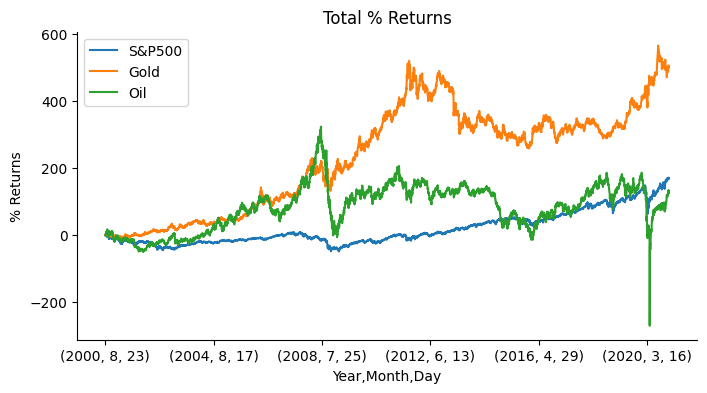

In [98]:
ax = range_asset_df[[*cum_cols.values()]].plot(kind='line', figsize=(8, 4), title=f'Total % Returns')
ax.set_ylabel('% Returns')
ax.legend(legend_text)
plt.gca().spines[['top', 'right']].set_visible(False)

display(range_asset_df[[*cum_cols.values()]].iloc[1:4])

##### **Conclusion**:

Plotting cumulative returns for a group of assets over a user-defined period shows how each asset's performance has changed compared to its starting value. Because the analysis relies on the chosen time frame, the results are specific to that historical period. This provides useful insight into long-term growth, volatility, and times of both outperformance and underperformance among different assets.

---

### Market Daily Direction Stats

In [ ]:
def overall_trend(row):
  row_t_count = row.count()
  if row.isna().any():
    return ''
  elif (row > 0).sum() == row_t_count:
    return 'Upward'
  elif (row < 0).sum() == row_t_count:
    return 'Downward'
  else:
    return 'Mixed'

In [ ]:
overall_trend_df = range_asset_df[[*perc_cols.values()]].reset_index()
overall_trend_df['OverAll_Trend'] = overall_trend_df[[*perc_cols.values()]].apply(overall_trend, axis=1)
overall_trend_df = overall_trend_df[~overall_trend_df['OverAll_Trend'].str.fullmatch('')]
overall_pivot_df = pd.pivot_table(overall_trend_df[['Month', 'OverAll_Trend', 'S&P500_%Return']], index='Month', columns='OverAll_Trend', aggfunc='count')
overall_pivot_df.columns = [a[1] for a in overall_pivot_df.columns.to_flat_index()]
overall_pivot_df.head(3)

,Downward,Mixed,Upward
Month,,,
1,49,264,66
2,44,250,62
3,64,289,82


### Monthly Returns Correlation

In [ ]:
corr_cols = {f'{x}' : f"""{x.replace('_%Return', '')}_Corr""" for x in perc_cols.values()}
corr_df = range_asset_df[[*corr_cols.keys()]].groupby(level=[1]).corr().unstack()
corr_df.columns = [f"""{"_".join(a).replace('_%Return', '')}_Corr""" for a in corr_df.columns.to_flat_index()]
corr_df = corr_df[['S&P500_Gold_Corr', 'S&P500_Oil_Corr', 'Gold_Oil_Corr']]
corr_df.head(3)

,S&P500_Gold_Corr,S&P500_Oil_Corr,Gold_Oil_Corr
Month,,,
1,-0.039107,0.312320,0.182149
2,-0.047966,0.166695,0.057820
3,0.068569,0.332126,0.252484


### Average Monthly Returns

In [ ]:
monthlyReturns = range_asset_df[[*perc_cols.values()]].groupby(['Year', 'Month']).sum().groupby('Month').mean()
monthlyReturns.head(3)

,S&P500_%Return,Gold_%Return,Oil_%Return
Month,,,
1,0.404372,3.203198,0.771125
2,-0.204774,1.120590,3.058619
3,0.326490,-0.174139,0.100080


### Alpha Beta Calculations

In [ ]:
beta_df = monthlyReturns.cov().iloc[0]/monthlyReturns.var().iloc[0]
alpha_beta_df = pd.DataFrame({'Beta' : beta_df,
                              'Alpha' : monthlyReturns.mean() - beta_df * monthlyReturns['S&P500_%Return'].mean()},
                             index=beta_df.index)
alpha_beta_df

,Beta,Alpha
S&P500_%Return,1.000000,1.110223e-16
Gold_%Return,0.019326,8.526212e-01
Oil_%Return,-2.793717,1.114315e+00


---

# Trends & Visualization

#### Asset Correlation

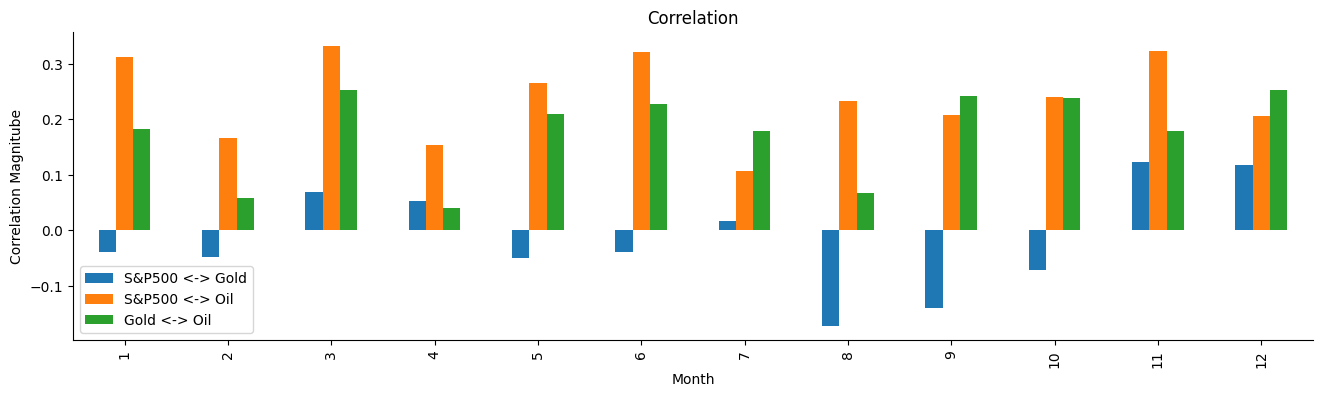

In [ ]:
ax = corr_df.plot(kind='bar', figsize=(16, 4), title=f'Correlation')
ax.set_ylabel('Correlation Magnitube')
ax.legend(['S&P500 <-> Gold', 'S&P500 <-> Oil', 'Gold <-> Oil'])
plt.gca().spines[['top', 'right']].set_visible(False)

#### Market Daily Overall Trend

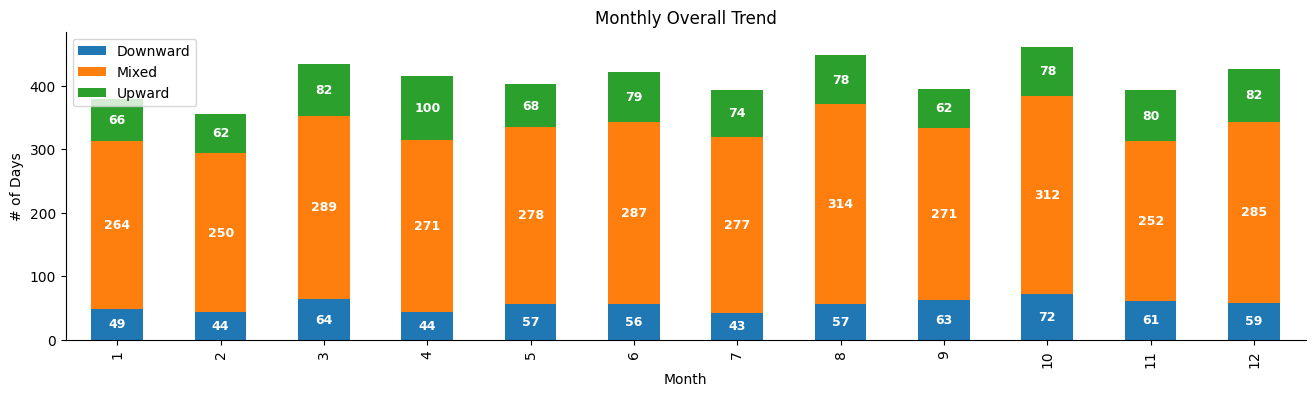

In [ ]:
ax = overall_pivot_df.plot(kind='bar', figsize=(16, 4), title=f'Monthly Overall Trend', stacked=True)
ax.set_ylabel('# of Days')
plt.gca().spines[['top', 'right']].set_visible(False)

for bar_container in ax.containers:
    for bar in bar_container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                        ha='center', va='center', color='white', fontsize=9, fontweight='bold')

#### Monthly Average Returns

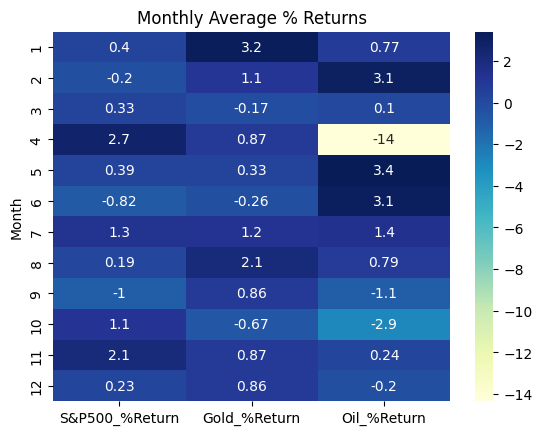

In [ ]:
ax = sb.heatmap(monthlyReturns, annot=True, cmap="YlGnBu")
ax.set_title('Monthly Average % Returns')
plt.show()

#### Alpha Beta Analysis

In [ ]:
def alpha_beta_plot(ab_df, alpha_col, beta_col, id_name, base_id_name, y_label, x_label, title):
  alpha = ab_df.loc[id_name, alpha_col];
  beta = ab_df.loc[id_name, beta_col];
  ax = sb.regplot(x=base_id_name, y=id_name, data=monthlyReturns);
  ax.plot([0, 0], [0, alpha], color='red', linewidth=2);
  ax.plot(0, alpha, marker='x', color='red', markersize=10, markeredgewidth=3);
  ax.spines['bottom'].set_position('zero');
  ax.spines['left'].set_position('zero');
  sb.despine();
  ax.set_xlabel(x_label);
  ax.set_ylabel(y_label);
  ax.xaxis.set_label_coords(0.5, -0.07);
  ax.yaxis.set_label_coords(-0.07, 0.5);
  ax.annotate(
    f'$\\alpha$ = {alpha: .2f}',
    xy=(0, alpha),
    xytext=(-0.9, 1.5),
    textcoords='data',
    color='black',
    fontsize=9,
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        lw=1,
        shrinkA=0, shrinkB=0
    )
  );

  ax.annotate(
    f'$\\beta$ = {beta: .2f}',
    xy=(0.5, alpha + (beta * 0.5)),
    xytext=(0.5, 2),
    textcoords='data',
    color='black',
    fontsize=9,
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        lw=1,
        shrinkA=0, shrinkB=0
    )
  );
  ax.set_title(f"Alpha ($\\alpha$) - Beta ($\\beta$ - Slope) of {title} Monthly Returns");

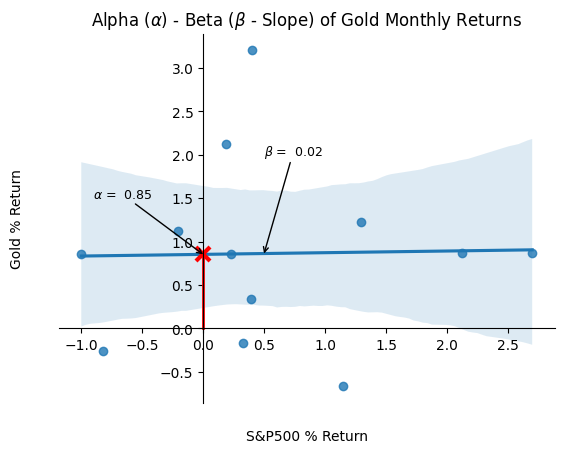

In [ ]:
alpha_beta_plot(alpha_beta_df, 'Alpha', 'Beta', 'Gold_%Return', 'S&P500_%Return', 'Gold % Return', 'S&P500 % Return', 'Gold')

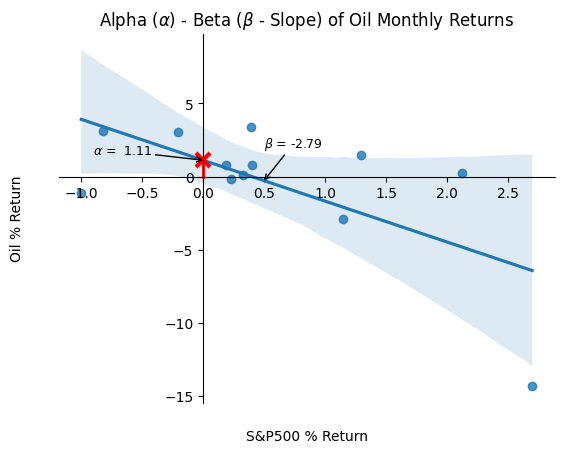

In [ ]:
alpha_beta_plot(alpha_beta_df, 'Alpha', 'Beta', 'Oil_%Return', 'S&P500_%Return', 'Oil % Return', 'S&P500 % Return', 'Oil')